In [ ]:
import pandas as pd
import numpy as np
import io
from sklearn.linear_model import LogisticRegression
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, log_loss
from sklearn.metrics import classification_report

In [ ]:
df_train = pd.read_csv('InsuranceData_train.csv')
print(df_train)

      M_SNC_MST_RCNT_ACT_OPN  TOT_HI_CRDT_CRDT_LMT  RATIO_BAL_TO_HI_CRDT  \
0                       92.0               24300.0               5.00000   
1                        2.0              259300.0               8.30000   
2                       23.0               11500.0               0.00000   
3                        9.0               33600.0               0.40000   
4                      367.0                 200.0               0.00000   
...                      ...                   ...                   ...   
9995                    78.0                   0.0              36.09828   
9996                    83.0                3000.0               0.00000   
9997                     9.0              235276.0              11.90000   
9998                   124.0                   0.0              36.09828   
9999                     5.0              565808.0              16.60000   

      AGRGT_BAL_ALL_XCLD_MRTG  N_OF_SATISFY_FNC_REV_ACTS  \
0                        12

In [ ]:
print(df_train.shape)

(10000, 69)


In [ ]:
frequency_table = df_train['PURCHASE'].value_counts()

print(frequency_table)

PURCHASE
0    7977
1    2023
Name: count, dtype: int64


In [ ]:
df_valid= pd.read_csv('InsuranceData_valid.csv')
print(df_valid)

      TREATMENT  PURCHASE  M_SNC_MST_RCNT_ACT_OPN  TOT_HI_CRDT_CRDT_LMT  \
0             0         0              347.000000                   0.0   
1             0         0                6.000000                4992.0   
2             1         0               29.883391                   0.0   
3             0         0              117.000000                   0.0   
4             1         0               95.000000               93553.0   
...         ...       ...                     ...                   ...   
9995          1         0                2.000000               98000.0   
9996          1         0                1.000000              145251.0   
9997          0         0               39.000000               44500.0   
9998          0         0              186.000000                1079.0   
9999          1         0                5.000000                 443.0   

      RATIO_BAL_TO_HI_CRDT  AGRGT_BAL_ALL_XCLD_MRTG  \
0                 36.09506                  

In [ ]:
print(df_train.shape)
print(df_valid.shape)

(10000, 69)
(10000, 70)


In [ ]:
def iv_woe(data, target, bins=10, show_woe=False):

    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()

    #Extract Column Names
    cols = data.columns

    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})


        # Calculate the number of events in each group (bin)
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']

        # Calculate % of events in each group.
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()

         # Calculate the non events in each group.
        d['Non-Events'] = d['N'] - d['Events']
        # Calculate % of non events in each group.
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()

        # Calculate WOE by taking natural log of division of % of non-events and % of events
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [ ]:
#Information Value

import numpy as np
import pandas as pd
np.random.seed(100)

newDF, woeDF = iv_woe(df_train,'PURCHASE', bins=10, show_woe=True)

Information value of M_SNC_MST_RCNT_ACT_OPN is 0.502863
                 Variable          Cutoff     N  Events  % of Events  \
0  M_SNC_MST_RCNT_ACT_OPN   (-0.001, 2.0]  1166     322     0.159170   
1  M_SNC_MST_RCNT_ACT_OPN      (2.0, 4.0]   912     243     0.120119   
2  M_SNC_MST_RCNT_ACT_OPN      (4.0, 7.0]  1051     278     0.137420   
3  M_SNC_MST_RCNT_ACT_OPN     (7.0, 11.0]   996     276     0.136431   
4  M_SNC_MST_RCNT_ACT_OPN    (11.0, 17.0]   964     236     0.116658   
5  M_SNC_MST_RCNT_ACT_OPN    (17.0, 27.0]   965     234     0.115670   
6  M_SNC_MST_RCNT_ACT_OPN  (27.0, 29.875]  1689      53     0.026199   
7  M_SNC_MST_RCNT_ACT_OPN  (29.875, 34.0]   291      75     0.037074   
8  M_SNC_MST_RCNT_ACT_OPN    (34.0, 67.0]   985     208     0.102818   
9  M_SNC_MST_RCNT_ACT_OPN   (67.0, 564.0]   981      98     0.048443   

   Non-Events  % of Non-Events       WoE        IV  
0         844         0.105804  0.408380  0.021793  
1         669         0.083866  0.359258  0.0

In [ ]:
print(newDF)

                           Variable        IV
0            M_SNC_MST_RCNT_ACT_OPN  0.502863
0              TOT_HI_CRDT_CRDT_LMT  0.886739
0              RATIO_BAL_TO_HI_CRDT  0.677171
0           AGRGT_BAL_ALL_XCLD_MRTG  0.259798
0         N_OF_SATISFY_FNC_REV_ACTS  0.260360
..                              ...       ...
0     D_NA_M_SNC_OLDST_MRTG_ACT_OPN  0.149410
0     D_NA_M_SNC_MST_RCNT_MRTG_DEAL  0.005086
0   D_NA_RATIO_PRSNL_FNC_BAL2HICRDT  0.038708
0                 D_N_DISPUTED_ACTS  0.070202
0                         UNIQUE_ID  0.005715

[68 rows x 2 columns]


In [ ]:
# Filtering newDF to find variables with IV less than 0.1
high_iv_variables = newDF[newDF['IV'] >= 0.1]['Variable']
print(high_iv_variables)
print(high_iv_variables.shape)

0             M_SNC_MST_RCNT_ACT_OPN
0               TOT_HI_CRDT_CRDT_LMT
0               RATIO_BAL_TO_HI_CRDT
0            AGRGT_BAL_ALL_XCLD_MRTG
0          N_OF_SATISFY_FNC_REV_ACTS
0           AVG_BAL_ALL_FNC_REV_ACTS
0         M_SNCOLDST_BNKINSTL_ACTOPN
0         M_SNC_MSTREC_INSTL_TRD_OPN
0           M_SNC_OLDST_MRTG_ACT_OPN
0               N_BC_ACTS_OPN_IN_24M
0            AVG_BAL_ALL_PRM_BC_ACTS
0         M_SNC_OLDST_RETAIL_ACT_OPN
0           RATIO_RETAIL_BAL2HI_CRDT
0          PRCNT_OF_ACTS_NEVER_DLQNT
0                    N_OPEN_REV_ACTS
0                 HI_RETAIL_CRDT_LMT
0        D_NA_M_SNC_MST_RCNT_ACT_OPN
0      D_NA_AVG_BAL_ALL_FNC_REV_ACTS
0    D_NA_M_SNCOLDST_BNKINSTL_ACTOPN
0      D_NA_M_SNC_OLDST_MRTG_ACT_OPN
Name: Variable, dtype: object
(20,)


In [ ]:
# Selecting these variables from the training_data DataFrame
selected_traindata = df_train[high_iv_variables.tolist()]

print(selected_traindata)
print(selected_traindata.shape)

      M_SNC_MST_RCNT_ACT_OPN  TOT_HI_CRDT_CRDT_LMT  RATIO_BAL_TO_HI_CRDT  \
0                       92.0               24300.0               5.00000   
1                        2.0              259300.0               8.30000   
2                       23.0               11500.0               0.00000   
3                        9.0               33600.0               0.40000   
4                      367.0                 200.0               0.00000   
...                      ...                   ...                   ...   
9995                    78.0                   0.0              36.09828   
9996                    83.0                3000.0               0.00000   
9997                     9.0              235276.0              11.90000   
9998                   124.0                   0.0              36.09828   
9999                     5.0              565808.0              16.60000   

      AGRGT_BAL_ALL_XCLD_MRTG  N_OF_SATISFY_FNC_REV_ACTS  \
0                        12

In [ ]:
selected_traindata.columns

Index(['M_SNC_MST_RCNT_ACT_OPN', 'TOT_HI_CRDT_CRDT_LMT',
       'RATIO_BAL_TO_HI_CRDT', 'AGRGT_BAL_ALL_XCLD_MRTG',
       'N_OF_SATISFY_FNC_REV_ACTS', 'AVG_BAL_ALL_FNC_REV_ACTS',
       'M_SNCOLDST_BNKINSTL_ACTOPN', 'M_SNC_MSTREC_INSTL_TRD_OPN',
       'M_SNC_OLDST_MRTG_ACT_OPN', 'N_BC_ACTS_OPN_IN_24M',
       'AVG_BAL_ALL_PRM_BC_ACTS', 'M_SNC_OLDST_RETAIL_ACT_OPN',
       'RATIO_RETAIL_BAL2HI_CRDT', 'PRCNT_OF_ACTS_NEVER_DLQNT',
       'N_OPEN_REV_ACTS', 'HI_RETAIL_CRDT_LMT', 'D_NA_M_SNC_MST_RCNT_ACT_OPN',
       'D_NA_AVG_BAL_ALL_FNC_REV_ACTS', 'D_NA_M_SNCOLDST_BNKINSTL_ACTOPN',
       'D_NA_M_SNC_OLDST_MRTG_ACT_OPN'],
      dtype='object')

In [ ]:
# Selecting these variables from the valid_data DataFrame
selected_validdata = df_valid[high_iv_variables.tolist()]
print(selected_validdata)
print(selected_validdata.shape)

      M_SNC_MST_RCNT_ACT_OPN  TOT_HI_CRDT_CRDT_LMT  RATIO_BAL_TO_HI_CRDT  \
0                 347.000000                   0.0              36.09506   
1                   6.000000                4992.0              77.70000   
2                  29.883391                   0.0              36.09506   
3                 117.000000                   0.0              36.09506   
4                  95.000000               93553.0              11.30000   
...                      ...                   ...                   ...   
9995                2.000000               98000.0               0.40000   
9996                1.000000              145251.0              12.50000   
9997               39.000000               44500.0               7.50000   
9998              186.000000                1079.0              36.09506   
9999                5.000000                 443.0             100.00000   

      AGRGT_BAL_ALL_XCLD_MRTG  N_OF_SATISFY_FNC_REV_ACTS  \
0                          

# Question 3

## Model creation and finding the optimal model

In [ ]:
# Instantiate a logistic regression model.
model = LogisticRegression(max_iter=10000)

# Fit the model to the training data.
model.fit(selected_traindata, df_train['PURCHASE'])

# Make predictions on the validation data.
predictions = model.predict(selected_validdata)

# Evaluate the model's performance.
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(df_valid['PURCHASE'], predictions)
print('Accuracy:', accuracy)

Accuracy: 0.8065


In [ ]:
# Define the parameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1.0, 10.0],
    'solver': ['liblinear', 'saga'],
    'random_state': [42, 123, 456]
}

# Define a scorer for the deviance (negative log-loss)
deviance_scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

# Create the GridSearchCV object
logistic_grid = GridSearchCV(
    LogisticRegression(max_iter=100),
    param_grid,
    scoring=deviance_scorer,
    cv=5,
    n_jobs=-1
)

# Fit the GridSearchCV object to the training data
logistic_grid.fit(selected_traindata, df_train['PURCHASE'])

# Get the optimal model
optimal_model = logistic_grid.best_estimator_
print("Best Parameters:", logistic_grid.best_params_)

Best Parameters: {'C': 10.0, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear'}


## Summary

We started by importing necessary libraries: `LogisticRegression` from `sklearn.linear_model`, `GridSearchCV` from `sklearn.model_selection`, and `make_scorer`, `log_loss` from `sklearn.metrics`. Next, we defined a parameter grid with different values for 'penalty', 'C', and 'solver' to explore various possibilities. Then, we created a scorer for deviance using `make_scorer`, setting it up to work with probability estimates. After that, we instantiated a `GridSearchCV` object named `logistic_grid`. This object used logistic regression with a maximum iteration of 10,000 and the parameter grid defined earlier. We set the scoring to use negative log loss (deviance) with 5-fold cross-validation, enabling parallel processing to utilize all available CPU cores.

Moving on, we fitted the `logistic_grid` object to the training data (`selected_traindata`) along with the corresponding target variable (`df_train['PURCHASE']`). We then extracted the best estimator (`optimal_model`) from the `logistic_grid` object and printed the best parameters. Subsequently, we made predictions on the validation data (`selected_validdata`) using the optimal model. Finally, we evaluated the optimal model's performance by calculating accuracy using `accuracy_score` and evaluating deviance (negative log loss) on the validation data.

## Comment on predictor variables

In [ ]:
newDF[newDF['IV'] >= 0.1]

,Variable,IV
0,M_SNC_MST_RCNT_ACT_OPN,0.502863
0,TOT_HI_CRDT_CRDT_LMT,0.886739
0,RATIO_BAL_TO_HI_CRDT,0.677171
0,AGRGT_BAL_ALL_XCLD_MRTG,0.259798
0,N_OF_SATISFY_FNC_REV_ACTS,0.260360
0,AVG_BAL_ALL_FNC_REV_ACTS,0.184061
0,M_SNCOLDST_BNKINSTL_ACTOPN,0.118144
0,M_SNC_MSTREC_INSTL_TRD_OPN,0.187704
0,M_SNC_OLDST_MRTG_ACT_OPN,0.182539
0,N_BC_ACTS_OPN_IN_24M,0.106883


In [ ]:
predictions = optimal_model.predict(selected_traindata)

# Evaluate the optimal model's performance
deviance = log_loss(df_train['PURCHASE'], optimal_model.predict_proba(selected_traindata))
accuracy = accuracy_score(df_train['PURCHASE'], predictions)
print('Accuracy:', accuracy)
print(f"Deviance (Log Loss) on Validation Data: {deviance:.4f}")

Accuracy: 0.8042
Deviance (Log Loss) on Validation Data: 0.4273


With a Learning Accuracy of 80% and a deviance of 0.4273, it suggests that the selected predictor variables are effective in predicting the target variable using the training data. This indicates that these variables are capturing important patterns or in the data. However in order to not be led astray by overfitting, we would have to test it with unseen data before we can validate this claim

## Making Predictions

In [ ]:
# Make predictions on the validation data
predictions = optimal_model.predict(selected_validdata)
predictions

array([0, 0, 0, ..., 0, 0, 0])

## Evaluating the Model

In [ ]:

print(classification_report(df_valid['PURCHASE'], predictions))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89      7987
           1       0.67      0.18      0.28      2013

    accuracy                           0.82     10000
   macro avg       0.75      0.58      0.59     10000
weighted avg       0.79      0.82      0.77     10000



Text(0.5, 1.0, 'Confusion Matrix')

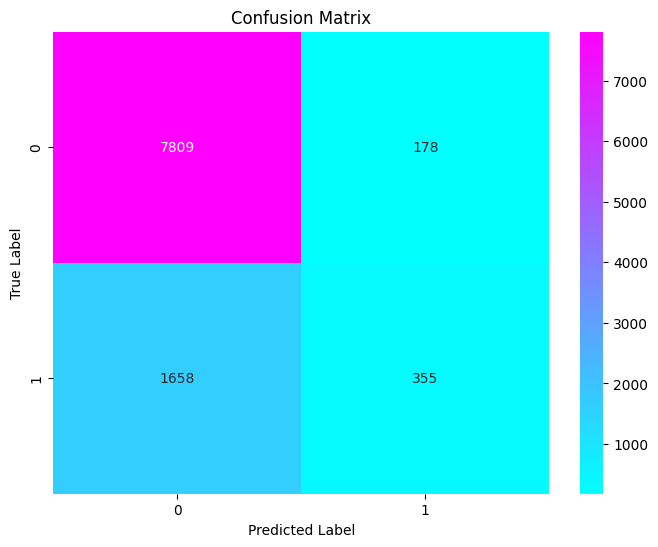

In [ ]:
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

# Create a confusion matrix
confusion_mat = confusion_matrix(df_valid['PURCHASE'], predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='cool')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

In [ ]:
# Calculate Sensitivity, Specificity, and Accuracy
sensitivity = confusion_mat[0, 0] / (confusion_mat[0, 0] + confusion_mat[0, 1])
specificity = confusion_mat[1, 1] / (confusion_mat[1, 0] + confusion_mat[1, 1])


# Print the results
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Accuracy:", accuracy)

# Evaluate the deviance on the validation data
deviance = log_loss(df_valid['PURCHASE'], optimal_model.predict_proba(selected_validdata))
print(f"Deviance (Log Loss) on Validation Data: {deviance:.4f}")

Sensitivity: 0.9777137849004632
Specificity: 0.17635370094386488
Accuracy: 0.8042
Deviance (Log Loss) on Validation Data: 0.4102


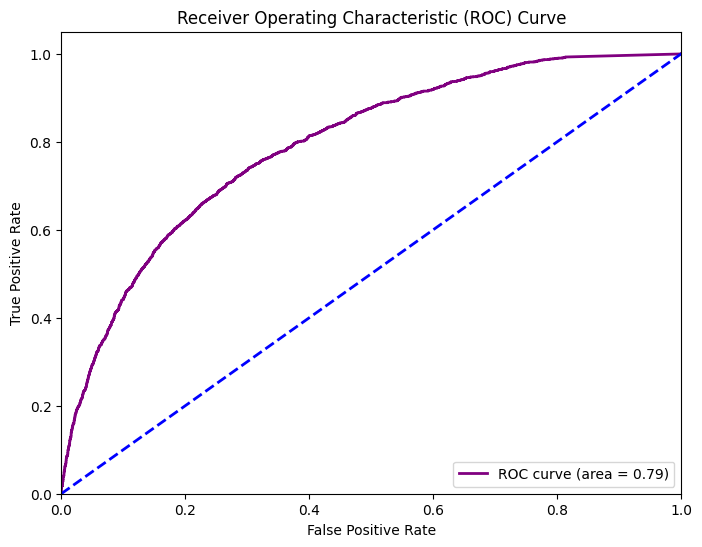

Area under the ROC curve: 0.7924998714067837


In [ ]:
from sklearn.metrics import roc_curve, auc

# Calculate the false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, _ = roc_curve(df_valid['PURCHASE'], optimal_model.predict_proba(selected_validdata)[:, 1])

# Calculate the area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print the AUC value
print('Area under the ROC curve:', roc_auc)


## Question 4

In [ ]:
X_train = selected_traindata
y_train = df_train['PURCHASE']

# Prepare the validation data
X_valid = selected_validdata
y_valid = df_valid['PURCHASE']

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create a scaler object
scaler = StandardScaler()

# Fit on training data and transform both training and validation data
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [ ]:
# Applying SMOTE to the training data
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

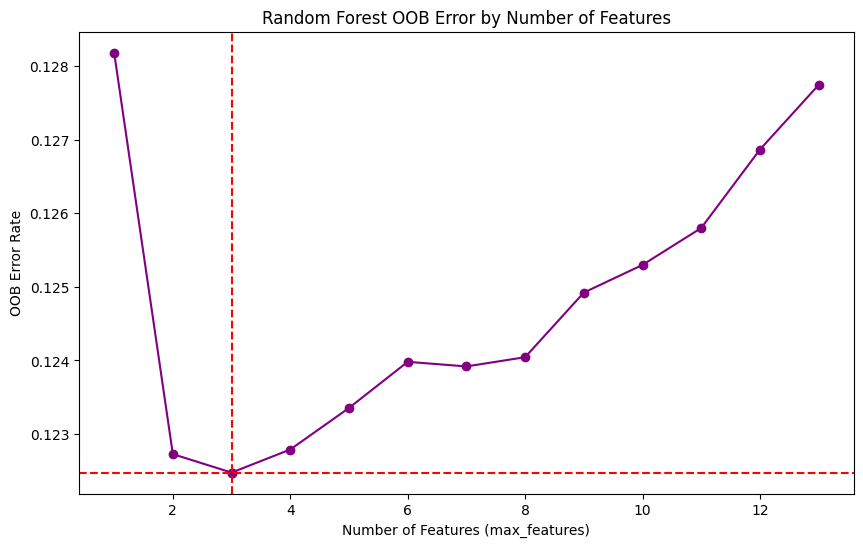

In [ ]:
from sklearn.ensemble import RandomForestClassifier

oob_errors = []
num_features = range(1, 14)  # Features to consider at each split
smote = SMOTE(random_state=423)

for i in num_features:
    # Apply SMOTE
    X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

    # Fit Random Forest
    rf = RandomForestClassifier(n_estimators=10001, max_features=i, oob_score=True, random_state=423, n_jobs=-1)
    rf.fit(X_train_smote, y_train_smote)
    oob_error = 1 - rf.oob_score_
    oob_errors.append(oob_error)

# Find the model with the lowest OOB error
min_oob_error = min(oob_errors)
best_features = num_features[oob_errors.index(min_oob_error)]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(num_features, oob_errors, marker='o',color='purple')
plt.scatter(best_features, min_oob_error, color='red')
plt.axhline(y=min_oob_error, linestyle='--', color='red')
plt.axvline(x=best_features, linestyle='--', color='red')
plt.title('Random Forest OOB Error by Number of Features')
plt.xlabel('Number of Features (max_features)')
plt.ylabel('OOB Error Rate')
plt.show()


In [ ]:


# Use the best model to make predictions on the validation data
best_model = rf  # Replace with the actual best model from your code
predictions = best_model.predict(X_valid_scaled)

# Print the predictions
print(predictions)


[0 0 0 ... 1 0 0]


In [ ]:
print(classification_report(df_valid['PURCHASE'], predictions))

              precision    recall  f1-score   support

           0       0.87      0.77      0.82      7987
           1       0.38      0.55      0.45      2013

    accuracy                           0.73     10000
   macro avg       0.62      0.66      0.63     10000
weighted avg       0.77      0.73      0.74     10000



Text(0.5, 1.0, 'Confusion Matrix')

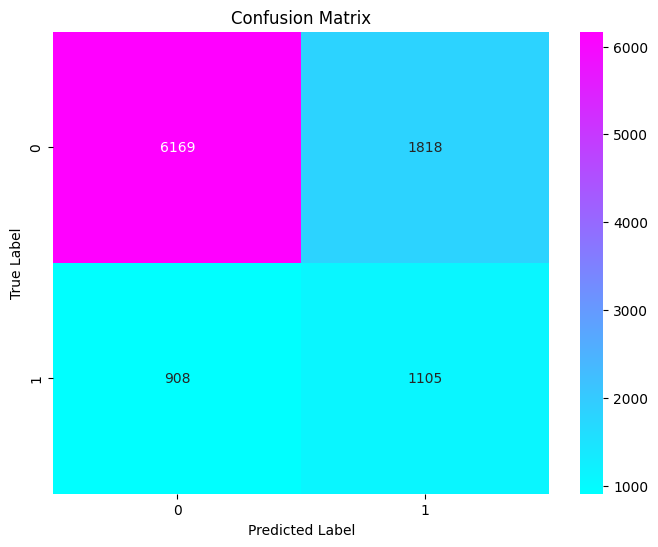

In [ ]:
# Create a confusion matrix
confusion_mat = confusion_matrix(y_valid, predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='cool')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

In [ ]:
# Calculate Sensitivity, Specificity, and Accuracy
sensitivity = confusion_mat[0, 0] / (confusion_mat[0, 0] + confusion_mat[0, 1])
specificity = confusion_mat[1, 1] / (confusion_mat[1, 0] + confusion_mat[1, 1])
accuracy = (confusion_mat[0, 0] + confusion_mat[1, 1]) / (confusion_mat[0, 0] + confusion_mat[0, 1] + confusion_mat[1, 0] + confusion_mat[1, 1])

# Print the results
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)
print("Accuracy:", accuracy)


Sensitivity: 0.7723801176912483
Specificity: 0.5489319423745653
Accuracy: 0.7274


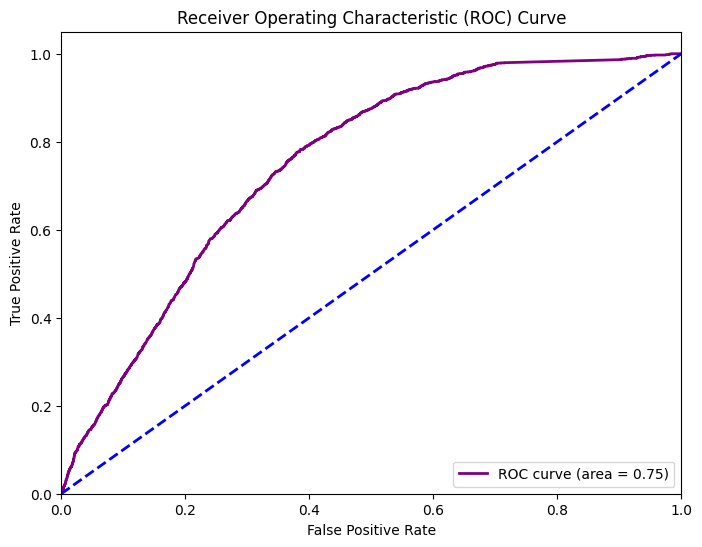

Area under the ROC curve: 0.7501571262939634


In [ ]:


# Calculate the false positive rate (FPR) and true positive rate (TPR)
fpr, tpr, _ = roc_curve(y_valid, best_model.predict_proba(X_valid_scaled)[:, 1])

# Calculate the area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='purple', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print the AUC value
print('Area under the ROC curve:', roc_auc)


## Question 5

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report


In [ ]:
# Building and training the SVM model using a polynomial kernel
svm_poly = SVC(kernel='poly', degree=3, C=0.01, random_state=423, probability=True)
svm_poly.fit(X_train_scaled, y_train)  # Use the scaled training data


SVC(C=0.01, kernel='poly', probability=True, random_state=423)

In [ ]:
# Building and training the SVM model using a Gaussian radial (RBF) kernel
svm_rbf = SVC(kernel='rbf', gamma=0.000001, C=0.01, random_state=423, probability=True)
svm_rbf.fit(X_train_scaled, y_train)  # Use the same scaled training data

SVC(C=0.01, gamma=1e-06, probability=True, random_state=423)

In [ ]:
# Making predictions with the polynomial kernel SVM
predictions_poly = svm_poly.predict(X_valid_scaled)

# Making predictions with the Gaussian RBF kernel SVM
predictions_rbf = svm_rbf.predict(X_valid_scaled)

In [ ]:
print(classification_report(df_valid['PURCHASE'], predictions_poly))


              precision    recall  f1-score   support

           0       0.80      1.00      0.89      7987
           1       0.73      0.02      0.03      2013

    accuracy                           0.80     10000
   macro avg       0.77      0.51      0.46     10000
weighted avg       0.79      0.80      0.72     10000



In [ ]:
print(classification_report(df_valid['PURCHASE'], predictions_rbf))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      7987
           1       0.00      0.00      0.00      2013

    accuracy                           0.80     10000
   macro avg       0.40      0.50      0.44     10000
weighted avg       0.64      0.80      0.71     10000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### SVM for Poly

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Training the SVM model without class weights
svm_poly_smote = SVC(kernel='poly', degree=3, C=0.01, random_state=423, probability=True)
svm_poly_smote.fit(X_train_smote, y_train_smote)

# Making predictions on the validation set
predictions_poly_smote = svm_poly_smote.predict(X_valid_scaled)

In [ ]:
print(classification_report(df_valid['PURCHASE'], predictions_poly_smote))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      7987
           1       0.44      0.56      0.50      2013

    accuracy                           0.77     10000
   macro avg       0.66      0.69      0.67     10000
weighted avg       0.79      0.77      0.78     10000



Text(0.5, 1.0, 'Confusion Matrix')

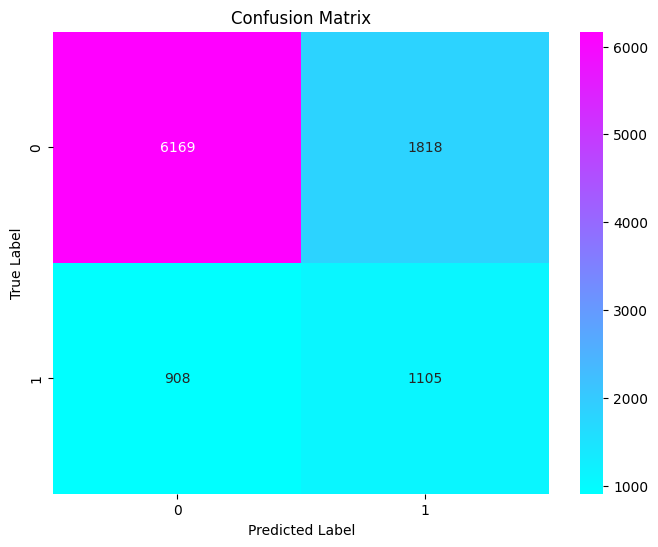

In [ ]:
# Evaluating the model
confusion_matrix_poly_smote = confusion_matrix(y_valid, predictions_poly_smote)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='cool')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')

Specificity: 0.568802781917536


In [ ]:
# Training the SVM model without class weights
svm_poly_smote = SVC(kernel='poly', degree=3, C=0.01, random_state=423, probability=True)
svm_poly_smote.fit(X_train_smote, y_train_smote)

# Making predictions on the validation set
predictions_poly_smote = svm_poly_smote.predict(X_valid_scaled)


classification_report_poly_smote = classification_report(y_valid, predictions_poly_smote)
print("\nClassification Report with SMOTE:")
print(classification_report_poly_smote)


Classification Report with SMOTE:
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      7987
           1       0.44      0.57      0.50      2013

    accuracy                           0.77     10000
   macro avg       0.66      0.69      0.67     10000
weighted avg       0.79      0.77      0.78     10000



Accuracy for Polynomial Kernel SVM with SMOTE: 0.7707


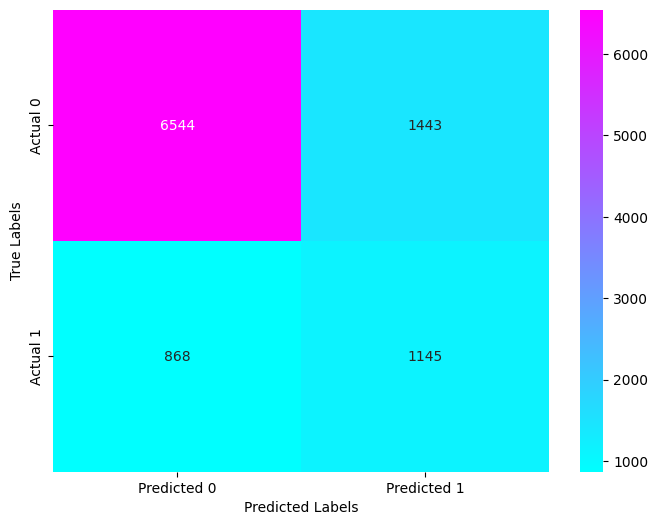

In [ ]:
accuracy_poly_smote = accuracy_score(y_valid, predictions_poly_smote)
print("Accuracy for Polynomial Kernel SVM with SMOTE:", accuracy_poly_smote)

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_poly_smote, annot=True, fmt="d", cmap="cool", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
#plt.title('Confusion Matrix Heatmap for Polynomial Kernel SVM with SMOTE')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:

specificity = confusion_matrix_poly_smote[1, 1] / (confusion_matrix_poly_smote[1, 0] + confusion_matrix_poly_smote[1, 1])

print("Specificity:", specificity)


Specificity: 0.568802781917536


<ipython-input-63-f54cd1908e26>:13: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)',color='blue')


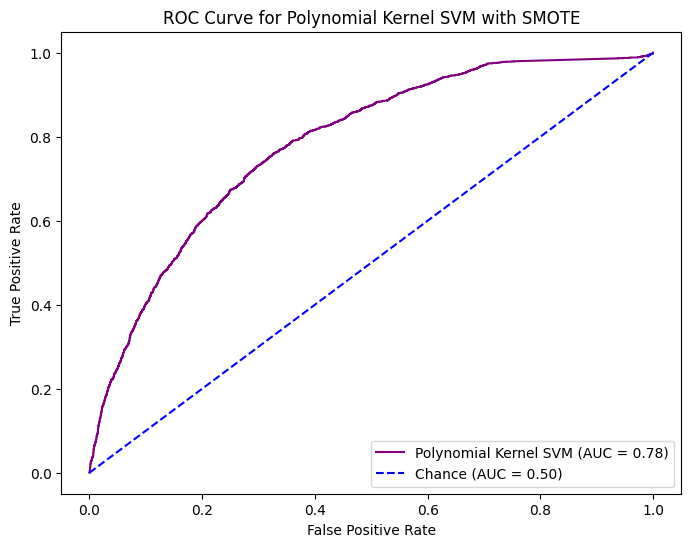

In [ ]:
# For Polynomial Kernel SVM with SMOTE
if hasattr(svm_poly_smote, "decision_function"):
    decision_scores_poly = svm_poly_smote.decision_function(X_valid_scaled)
else:
    decision_scores_poly = svm_poly_smote.predict_proba(X_valid_scaled)[:, 1]

fpr_poly, tpr_poly, _ = roc_curve(y_valid, decision_scores_poly)
auc_poly = auc(fpr_poly, tpr_poly)

# Plotting ROC Curve for Polynomial Kernel SVM
plt.figure(figsize=(8, 6))
plt.plot(fpr_poly, tpr_poly, label=f'Polynomial Kernel SVM (AUC = {auc_poly:.2f})',color='purple')
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)',color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Polynomial Kernel SVM with SMOTE')
plt.legend(loc="lower right")
plt.show()

### SVM for RBF

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

svm_rbf_smote = SVC(kernel='rbf', gamma=0.000001, C=0.01, class_weight='balanced', random_state=423)
svm_rbf_smote.fit(X_train_smote, y_train_smote)
predictions_rbf_smote = svm_rbf_smote.predict(X_valid_scaled)

print(classification_report(y_valid, predictions_rbf_smote))

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      7987
           1       0.38      0.72      0.49      2013

    accuracy                           0.70     10000
   macro avg       0.64      0.71      0.64     10000
weighted avg       0.80      0.70      0.73     10000



Accuracy for Gaussian RBF Kernel SVM with SMOTE: 0.702


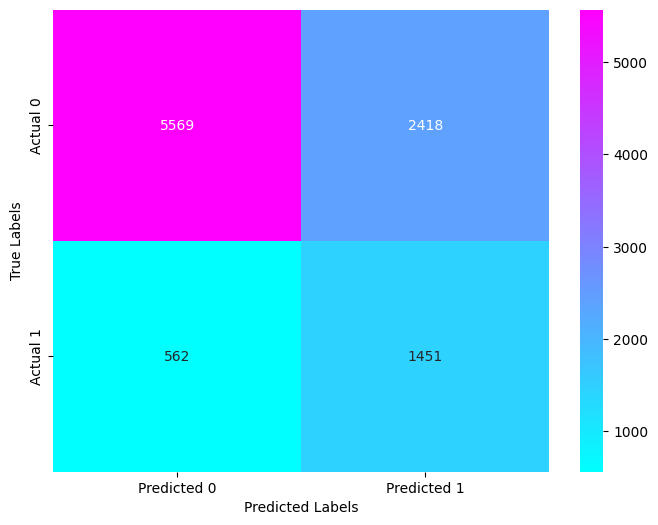

In [ ]:
accuracy_rbf_smote = accuracy_score(y_valid, predictions_rbf_smote)
print("Accuracy for Gaussian RBF Kernel SVM with SMOTE:", accuracy_rbf_smote)

# Generate and display the confusion matrix heatmap
confusion_matrix_rbf_smote = confusion_matrix(y_valid, predictions_rbf_smote)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_rbf_smote, annot=True, fmt="d", cmap="cool", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:

specificity = confusion_matrix_rbf_smote[1, 1] / (confusion_matrix_rbf_smote[1, 0] + confusion_matrix_rbf_smote[1, 1])

print("Specificity:", specificity)


Specificity: 0.7208147044212618


<ipython-input-67-fd2cb1dad90b>:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)',color='blue')


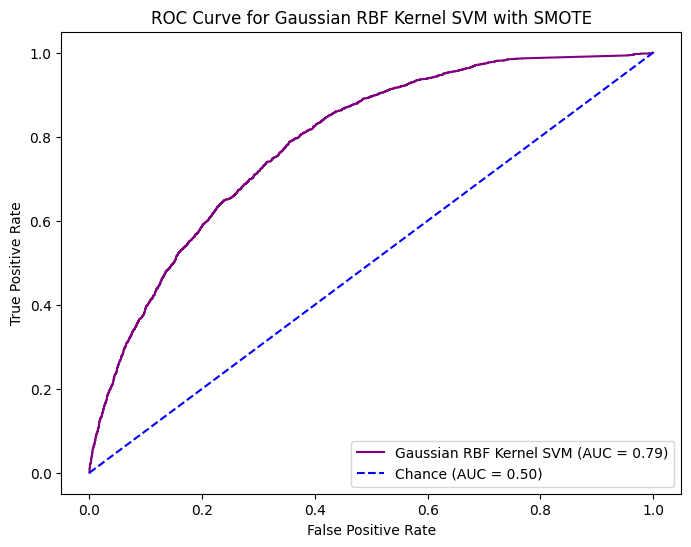

In [ ]:


if hasattr(svm_rbf_smote, "decision_function"):
    decision_scores_rbf = svm_rbf_smote.decision_function(X_valid_scaled)
else:
    decision_scores_rbf = svm_rbf_smote.predict_proba(X_valid_scaled)[:, 1]

fpr_rbf, tpr_rbf, _ = roc_curve(y_valid, decision_scores_rbf)
auc_rbf = auc(fpr_rbf, tpr_rbf)

# Plotting ROC Curve for Gaussian RBF Kernel SVM
plt.figure(figsize=(8, 6))
plt.plot(fpr_rbf, tpr_rbf, label=f'Gaussian RBF Kernel SVM (AUC = {auc_rbf:.2f})',color='purple')
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)',color='blue')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Gaussian RBF Kernel SVM with SMOTE')
plt.legend(loc="lower right")
plt.show()